# CNN architectures for CIFAR-10 classification

CIFAR-10 is a famous collection of small color images, each 32 x 32 pixels.  There are 6,000 images in each of 10 classes.

https://www.cs.toronto.edu/~kriz/cifar.html

It is good when starting to work with CNNs.  In this assignment you will play with a CNN model to obtain the best
test accuracy on CIFAR-10.

## Instructions

In the code below, a baseline CNN classifier is created.  Your job is to code and run a bunch of experiments to see the effect of changes to the CNN classifier. 

Read the code, and look for problem prompts.

Run your code from top to bottom before submitting.


## Instructions

Section 9.4.1 of our Chollet text shows how to visualize intermediate activations.  Apply the ideas in that section to a CNN CIFAR model.  

Copy this notebook as your starting point.

Chollet's book is available in the O'Reilly Learning Center.

You probably want to steal code from Chollet's [notebook for the part of chapter 9 on visualizing CNNs](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part03_interpreting-what-convnets-learn.ipynb).


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

/var/folders/qh/wybqz5g16cl72p8y8_w08npr0000gn/T/ipykernel_57976/2444071212.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

This will help with replicability, but does not control all aspects of randomness in the code.

In [4]:
np.random.seed()

### Read the data

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [7]:
print(X_train.min(), X_train.max())
print(np.unique(y_train))

0 255
[0 1 2 3 4 5 6 7 8 9]


#### We'll use a smaller version of the data to speed up the training process.

In [8]:
num_train = 25000
num_test = 8000
X_train = X_train[:num_train]
y_train = y_train[:num_train]
X_test = X_test[:num_test]
y_test = y_test[:num_test]

### Preprocess the data

In [9]:
# from integers in [0,255] to float in [0,1]
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32') / 255

# one hot encoding
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 32, 32, 3)
(25000, 10)
(8000, 32, 32, 3)
(8000, 10)


### CNN model

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(32,32,3)))
model.add(layers.Conv2D(32, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
# classification part
model.add(layers.Dense(10, activation='softmax'))

/Users/ssogden/miniconda3/envs/cst463/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-30 09:21:55.860525: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-10-30 09:21:55.860544: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-10-30 09:21:55.860551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-10-30 09:21:55.860565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 09:21:55.860579: I tensorflow/core/common_runtime/pluggable_device/pluggable_

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        23,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,690 (201.91 KB)

 Trainable params: 51,690 (201.91 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and train the model

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.3)

Epoch 1/5


2024-10-30 09:21:56.465734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.2627 - loss: 2.0213 - val_accuracy: 0.4093 - val_loss: 1.6568
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4659 - loss: 1.5179 - val_accuracy: 0.5279 - val_loss: 1.3579
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5456 - loss: 1.3133 - val_accuracy: 0.5641 - val_loss: 1.2446
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5894 - loss: 1.1802 - val_accuracy: 0.6032 - val_loss: 1.1820
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6226 - loss: 1.0925 - val_accuracy: 0.5964 - val_loss: 1.1810


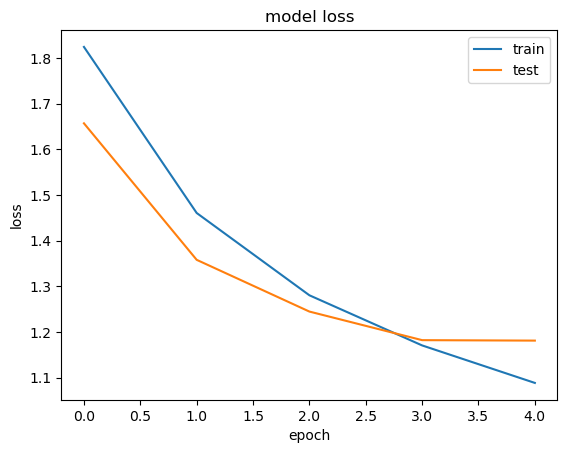

In [14]:
plot_metric(history)

In [15]:
# get a single image
idx = np.random.choice(X_test.shape[0])
X = X_test[[idx]]